In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

In [2]:
data_transform = transforms.ToTensor()

train_data = FashionMNIST(root='./data', train=True, download=True, transform=data_transform)
test_data = FashionMNIST(root='./data', train=False, download=True, transform=data_transform)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(len(train_data))
print(len(test_data))

60000
10000


In [10]:
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=16)

In [6]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [9]:
print(images.shape)
print(labels.shape)

torch.Size([20, 1, 28, 28])
torch.Size([20])


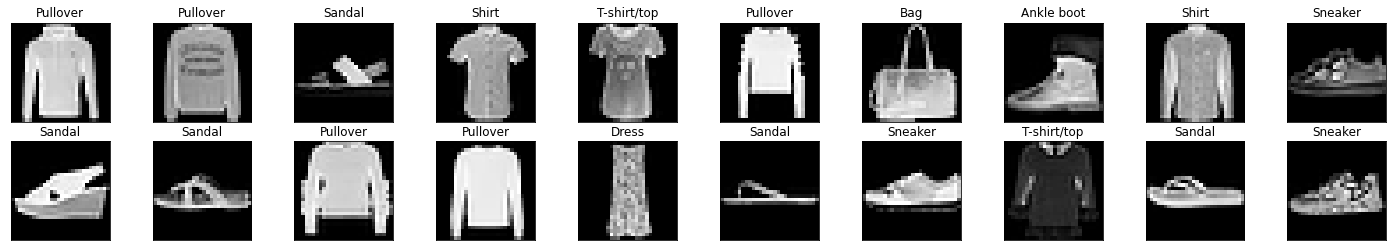

In [11]:
# visualizing one batch

fig = plt.figure(figsize=(25,4))
for idx in np.arange(batch_size):
  ax = fig.add_subplot(2,batch_size/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(classes[labels[idx]])

In [13]:
class Net(nn.Module):
  def __init__(self, num_classes):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))

    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.5)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(16*7*7, num_classes)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    return x

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
net = Net(10).to(device)
x = torch.randn(20, 1, 28, 28, device=device)
output = net(x)
print(output.shape)

torch.Size([20, 10])


In [16]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, momentum=0.9)

In [20]:
def test(net):
  net.eval()
  total = 0
  correct = 0

  for batch_idx, data in enumerate(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      output = net(images)

      prediction = F.softmax(output.float(), dim=1)
      _, prediction = torch.max(prediction, dim=1)

      total += labels.size(0)
      correct += (prediction == labels).sum()

    accuracy = 100 * correct / total

  print(f'Test accuracy: {accuracy:.2f}%')

In [17]:
def train(epochs, net):
  for epoch in range(epochs):
    training_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      outputs = net(images)

      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      training_loss += loss.item()

    print(f'Epoch: {epoch+1}/{epochs}\t Training Loss: {training_loss/len(train_loader):.6f}')
  print('Finished Training!')

In [18]:
epochs = 20
train(epochs, net)

Epoch: 1/20	 Training Loss: 0.802885
Epoch: 2/20	 Training Loss: 0.482171
Epoch: 3/20	 Training Loss: 0.421846
Epoch: 4/20	 Training Loss: 0.393411
Epoch: 5/20	 Training Loss: 0.372697
Epoch: 6/20	 Training Loss: 0.355225
Epoch: 7/20	 Training Loss: 0.341524
Epoch: 8/20	 Training Loss: 0.330900
Epoch: 9/20	 Training Loss: 0.320624
Epoch: 10/20	 Training Loss: 0.315312
Epoch: 11/20	 Training Loss: 0.307976
Epoch: 12/20	 Training Loss: 0.301010
Epoch: 13/20	 Training Loss: 0.296336
Epoch: 14/20	 Training Loss: 0.291855
Epoch: 15/20	 Training Loss: 0.287878
Epoch: 16/20	 Training Loss: 0.283958
Epoch: 17/20	 Training Loss: 0.280177
Epoch: 18/20	 Training Loss: 0.277386
Epoch: 19/20	 Training Loss: 0.274466
Epoch: 20/20	 Training Loss: 0.271471
Finished Training!


In [21]:
test(net)

Test accuracy: 89.08%


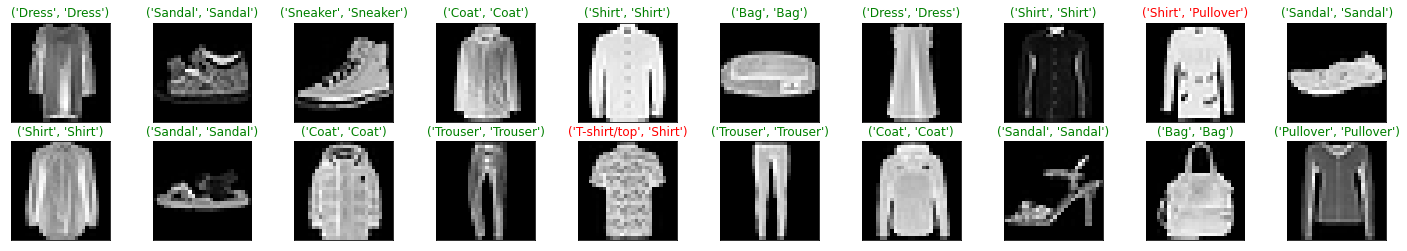

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
with torch.no_grad():
  output = net(images.to(device))
  preds = F.softmax(output.float(), dim=1)
  _, preds = torch.max(preds, dim=1)

  images = images.numpy()

  # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(batch_size):
      ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(images[idx]), cmap='gray')
      ax.set_title(f'{classes[preds[idx]], classes[labels[idx]]}', color=("green" if preds[idx]==labels[idx] else "red"))

In [117]:
## TODO: change the model_name to something uniqe for any new model
## you wish to save, this will save it in the saved_models directory
model_dir = 'saved_models/'
model_name = 'model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
torch.save(net.state_dict(), model_dir+model_name)

In [ ]:
# instantiate your Net
# this refers to your Net class defined above
net = Net()

# load the net parameters by name
# uncomment and write the name of a saved model
net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

# Once you've loaded a specific model in, you can then 
# us it or further analyze it! 
# This will be especialy useful for feature visualization

### Feature Visualization

(8, 1, 3, 3)
First Convolution Layer


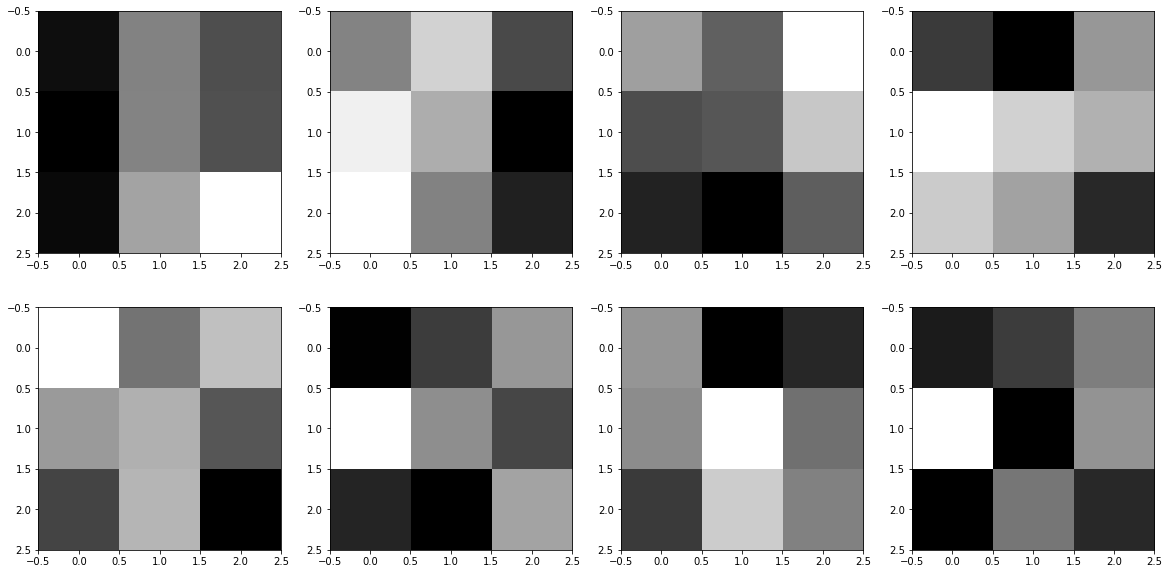

In [30]:
# Get the weights in the first conv layer
weights = net.conv1.weight.data.cpu()
w = weights.numpy()
print(w.shape)

# for 8 filters
fig = plt.figure(figsize=(20,10))
columns = 4
rows = 2

for i in range(0, columns*rows):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(w[i][0], cmap='gray')

print('First Convolution Layer')
plt.show()

In [ ]:
# Applying one of the trained filter to one of the images from test dataset

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

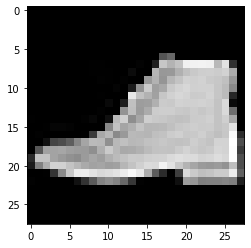

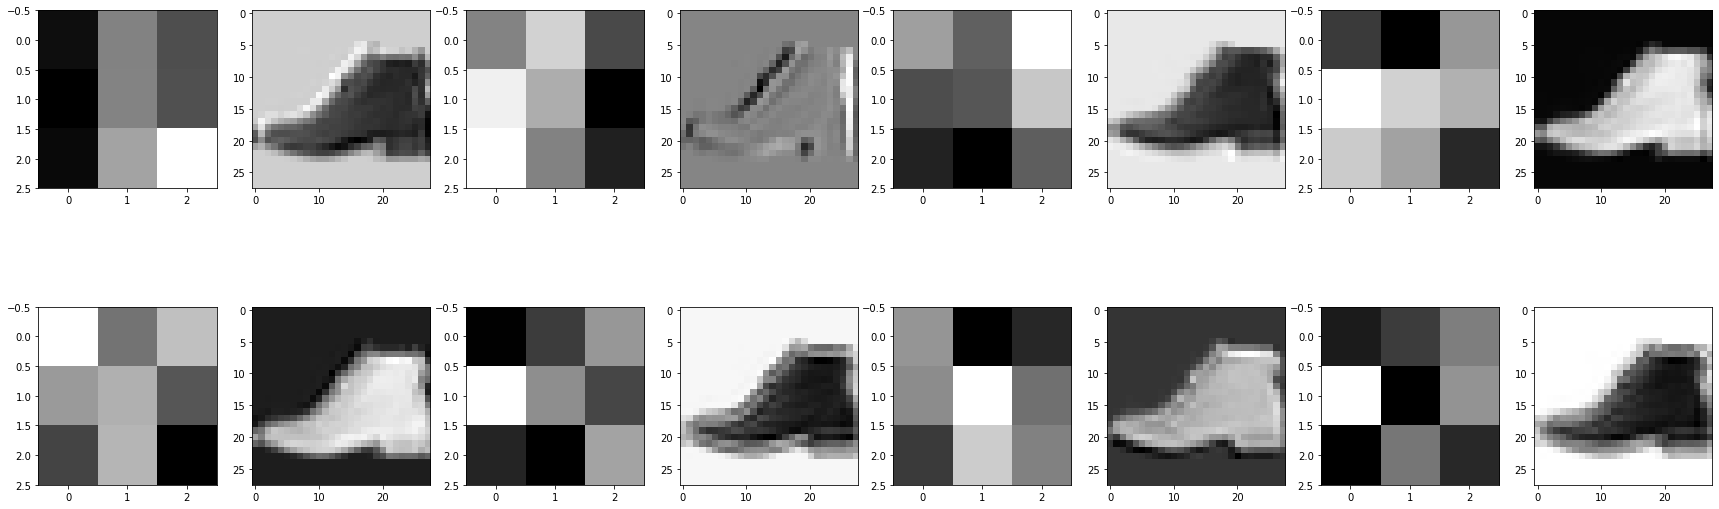

In [40]:
idx = 2
img = np.squeeze(images[idx])
plt.imshow(img, cmap='gray')

import cv2
weights = net.conv1.weight.data.cpu()
w = weights.numpy()


fig=plt.figure(figsize=(30, 10))
columns = 4*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()


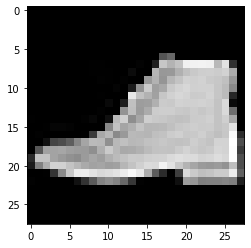

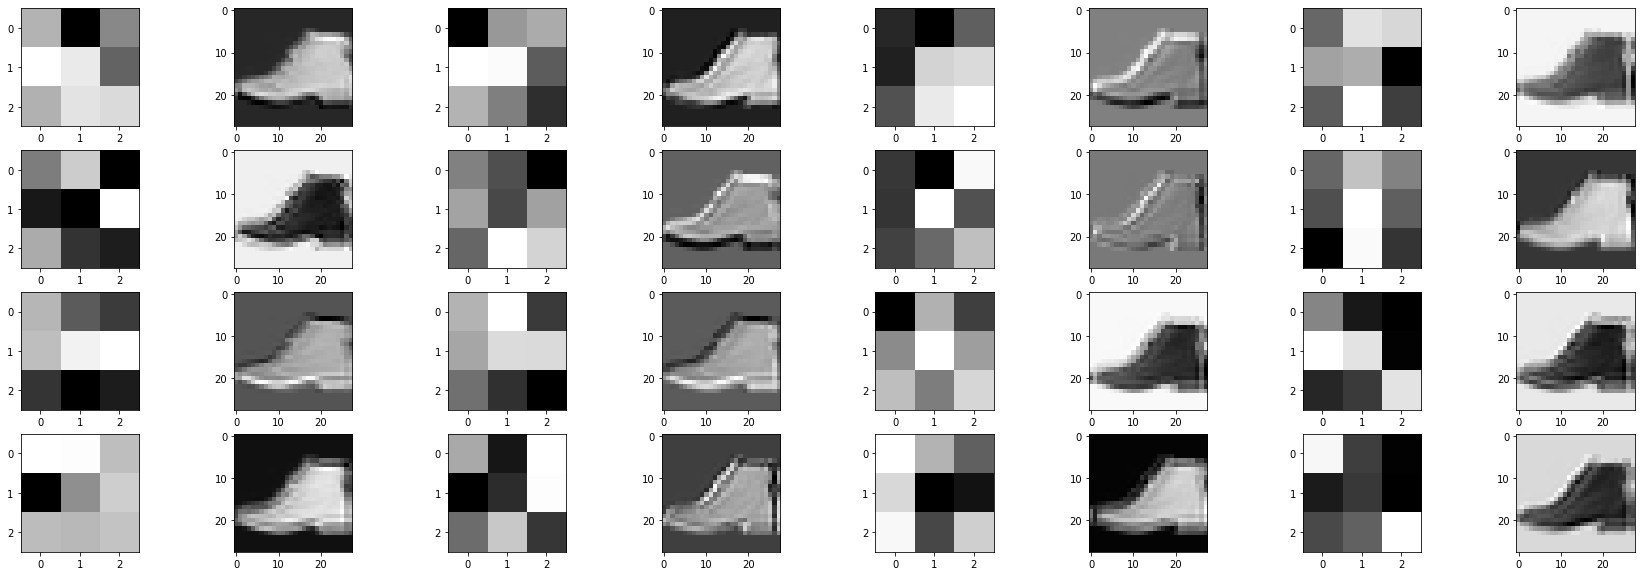

In [43]:
plt.imshow(img, cmap='gray')

# second conv layer, conv2
weights = net.conv2.weight.data.cpu()
w = weights.numpy()

# 1. first conv layer
# for 20 filters
fig=plt.figure(figsize=(30, 10))
columns = 4*2
rows = 2*2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()